# M3 – Week 2
### Bag of Visual Words for Image Classification

#### Team 6
- Alex Carrillo Alza
- Eduard Hogea
- Guillem Martinez Sanchez


### **Table of Contents**

*   [1. Work from Week 1](#week_1)
*   [2. Dataset](#dataset)
*   [3. Dense SIFT](#dense-sift)
*   [4. Normalization](#normalization)
*   [5. Spatial Pyramids](#pyramids)
    *   [5.1. Square pyramid regions](#square)
    *   [5.2. Horizontal pyramid regions](#horizontal)
*   [3. SVM Classifier](#svm)

## 1. Work from Week 1 <a id="week_1"></a>

### Imports

In [156]:
import os
import cv2
import numpy as np
import pickle
import json
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from tqdm import tqdm
from joblib import Parallel, delayed, cpu_count
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from typing import List, Dict, Tuple, Any
from copy import deepcopy
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model._base import BaseEstimator
from copy import deepcopy
import pandas as pd
from pylab import rcParams
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
from sklearn import svm
import seaborn as sns
from sklearn.preprocessing import normalize, StandardScaler

<IPython.core.display.Javascript object>

### Generic functions <a id="functions"></a>

In [3]:
def compute_visual_words(descriptors: np.ndarray, desc: str, codebook: MiniBatchKMeans, codebook_size: int = 128, verbose: bool = False) -> np.ndarray:
    """
    Computes the visual words of a set of descriptors given a codebook
    """
    visual_words = np.zeros((len(descriptors), codebook_size), dtype=np.float32)
    not_det = 0
    for i in tqdm(range(len(descriptors)), desc=desc, position=0, leave=verbose):
        if descriptors[i] is None:
            not_det += 1
            visual_words[i,:] = np.zeros(codebook_size, dtype=np.float32)
        else:
            words = codebook.predict(descriptors[i])
            visual_words[i,:] = np.bincount(words, minlength=codebook_size)
    if verbose:
        print(f"\nGenerated {visual_words.shape[0]} histograms with a k={visual_words.shape[1]} vocabulary.")
        print(f'\nNumber of images where keypoints were not detected: {not_det}')
    return visual_words

In [4]:
def dimensionality_reduction(X_train: np.ndarray, Y_train: np.ndarray, X_validate: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    This function applies dimensionality reduction to the training and validation data.

    Args:
        trial (int): The trial number
        X_train (np.ndarray): The training data
        Y_train (np.ndarray): The training labels, needed for supervised dimensionality reduction
        X_validate (np.ndarray): The validation data
    """
    lda = LinearDiscriminantAnalysis(n_components=7) # 7 is the best parameter from last week, no need to do hyperparam search
    X_train_DR = lda.fit_transform(X_train, Y_train)
    X_validate_DR = lda.transform(X_validate)

    return X_train_DR, X_validate_DR

In [5]:
def evaluate_vw_predictions(visual_words,test_labels, knn):
    """
    This function prints and returns the predictions' accuracy
    """
    score = knn.score(visual_words, test_labels)
    print(f'\nThe trained model generates results with {100*score} accuracy.')
    return score

In [6]:
def compute_image_descriptors(image: np.ndarray, detector_name: str, detector, step_size: int, kp_sizes: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute descriptors for an image using a feature detector.
    """
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    if detector_name == 'dense_sift':
        keypoints = create_dense_kp(gray.shape, step_div_size=step_size, kp_sizes = kp_sizes)
        _, descriptors = detector.compute(gray, keypoints)
    else:
        keypoints, descriptors = detector.detectAndCompute(gray, None)
    return keypoints, descriptors

def compute_descriptors(
    images: List[np.ndarray],
    labels: Tuple,
    detector: str,
    n_features: int,
    desc: str,
    step_div_size: int = 10,
    n_process: int = cpu_count(),
    verbose: bool = False,
    testing: bool = False,
    kp_sizes: int = 1
    ):
    """
    Compute descriptors for an image using a feature detector.
    Descriptors are filtered (because images without descriptors are not useful)
    and a numpy array with all the descriptors stacked together is built.
    """
    detector_name, detector = get_detector(detector, n_features)
    features = Parallel(n_jobs=n_process, prefer="threads")(
        delayed(compute_image_descriptors)(img, detector_name, detector, step_div_size, kp_sizes) for img in tqdm(images, desc=desc, position=0, leave=verbose))
    _, descriptors = list(zip(*features))
    filtered_descriptors, filtered_labels = zip(*[(x, y) for x, y in zip(descriptors, labels) if x is not None])
    if verbose:
        print(f"\nprocessed {len(descriptors)} images, {detector.getDefaultName()} descriptors of n_features={n_features}")
        print(f"\n{len(descriptors) - len(filtered_descriptors)} images without keypoints (nor descriptors)")
    if testing: 
        return descriptors, labels
    return filtered_descriptors, filtered_labels

In [7]:
def get_detector(name: str = 'sift', n_features: int = 100) -> Any:
    if name == 'kaze':
        detector = cv2.KAZE_create()
    elif name == 'akaze':
        detector = cv2.AKAZE_create(descriptor_size=n_features)
    elif name == 'brisk':
        detector = cv2.BRISK_create()
    elif name == 'sift':
        detector = cv2.SIFT_create(nfeatures=n_features)
    elif name == 'dense_sift':
        detector = cv2.SIFT_create(nfeatures=n_features)
    else:
        raise ValueError(
            f"Given detector {name} is an invalid one."
        )
    return name, detector

In [8]:
def load_images(files: List[str], desc: str, n_process: int = cpu_count()) -> Tuple[np.ndarray]:
    """
    Load a list of images by their full filenames.
    """
    images = Parallel(n_jobs=n_process, prefer="threads")(
        delayed(load_image)(file) for file in tqdm(files, desc=desc))
    print(f"read: {len(images)} images")
    return images
def load_image(path: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Load image at path.
    """
    return cv2.imread(path)

In [9]:
def generate_codebook(descriptors: np.ndarray, codebook_size: int = 128) -> MiniBatchKMeans:
    """
    Generates a codebook from a given ndarray containing descriptors. Mainly, training descriptors
    """
    D = np.vstack(descriptors)
    codebook = MiniBatchKMeans(n_clusters=codebook_size, verbose=False, batch_size=128 * 20, compute_labels=False,
        reassignment_ratio=10**-4, random_state=42)
    codebook.fit(D)
    return codebook

## 1. Dataset <a id="dataset"></a>

Read train and test files.

In [36]:
train_images_filenames = pickle.load(open('../MIT_split/train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('../MIT_split/test_images_filenames.dat','rb'))
train_labels = pickle.load(open('../MIT_split/train_labels.dat','rb'))
test_labels = pickle.load(open('../MIT_split/test_labels.dat','rb'))

Define dataset class to manage data and visualize the images samples.

In [37]:
class Dataset():
    def __init__(self, images_filenames, labels):
        self.data = images_filenames
        self.labels = labels
    
    def visualize(self, samples_per_class=5):
        print(f'Total number of training samples: {len(self.data)}')
        # get unique classses
        classes = np.unique(np.array(self.labels))
        num_classes = len(classes)
        #set size for plot
        plt.figure(figsize=(12,6))

        for y, cls in enumerate(classes):
            _idxs = np.flatnonzero(np.array(self.labels) == cls)
            idxs = np.random.choice(_idxs, samples_per_class, replace=False)
            for i, idx in enumerate(idxs):
                plt_idx = i * num_classes + y + 1
                plt.subplot(samples_per_class, num_classes, plt_idx)
                plt.imshow(Image.open(self.data[idx]))
                plt.axis('off')
                if i == 0:
                    plt.title(f'{cls} ({len(_idxs)})', fontsize=9)
        plt.show()
        
    def show_sample(self, indx):
        return Image.open(self.data[indx])


train = Dataset(train_images_filenames, train_labels)
test = Dataset(test_images_filenames, test_labels)

Total number of training samples: 1881


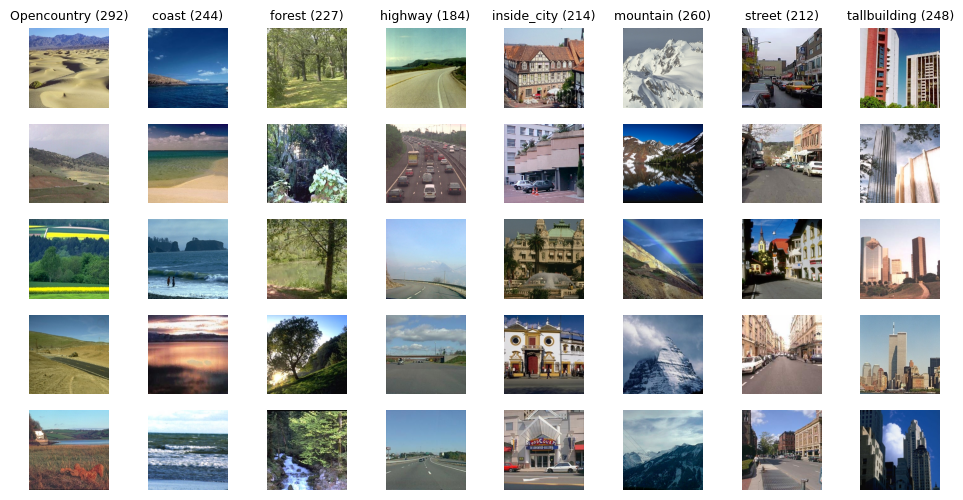

In [38]:
train.visualize()

Total number of training samples: 807


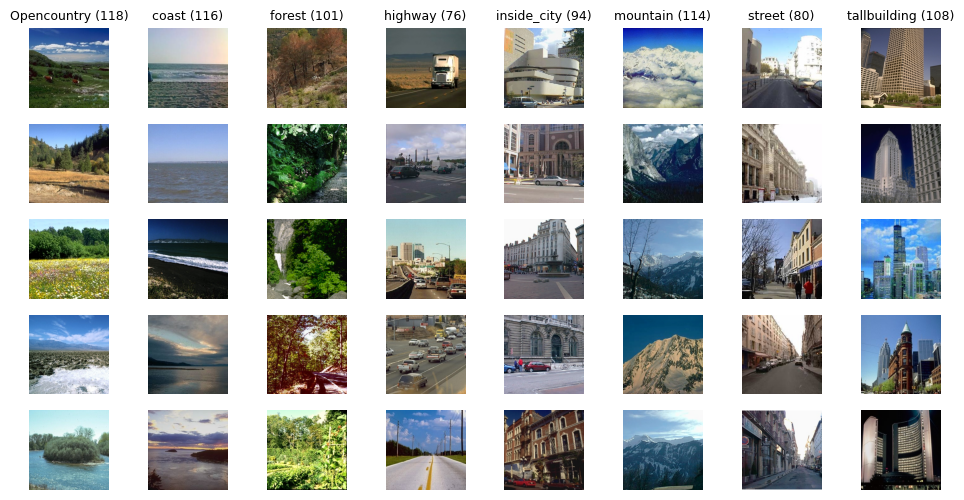

In [39]:
test.visualize()

### Class distributions per subset <a id="functions"></a>

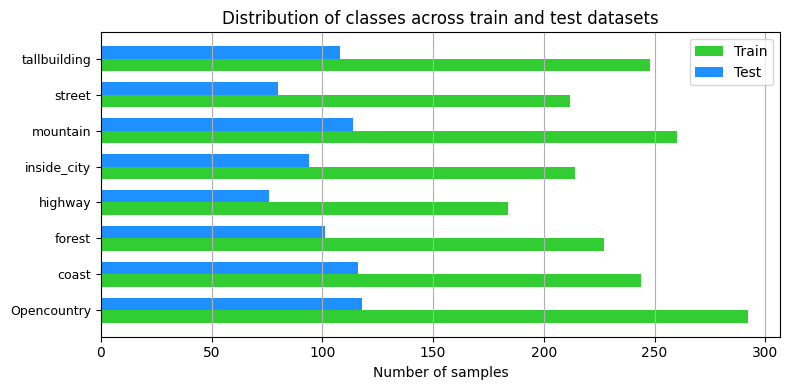

In [55]:
unique_labels = np.sort(np.unique(train_labels))
train_count = [np.sum(np.array(train_labels) == label) for label in unique_labels]
test_count = [np.sum(np.array(test_labels) == label) for label in unique_labels]

x = np.arange(len(unique_labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(x - width/2, train_count, width, label='Train', color='limegreen')
ax.barh(x + width/2, test_count, width, label='Test', color='dodgerblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Number of samples')
ax.set_title('Distribution of classes across train and test datasets')
ax.set_yticks(x)
ax.set_yticklabels(unique_labels, fontsize=9)
ax.legend()
ax.grid(axis='x')

fig.tight_layout()

plt.show()

## 3. Dense SIFT <a id="dense-sift"></a>

We have implemented Dense SIFT by creating a grid of keypoints that are spatially equidistant. 

Previously, the distance between keypoints was defined by the "step_size" parameter in pixels. However, we have now changed the algorithm so that the distance is based on the size of the image and is determined by the "step_div_size" parameter. 

In [200]:
# To create dense keypoints by step size and scale factor
def create_dense_kp(img_shape, step_div_size=50, kp_sizes=1):
    keypoints = []
    init_step_size_x = max(img_shape[1] // step_div_size, 8)
    init_step_size_y = max(img_shape[0] // step_div_size, 8)
    for i in range(1, kp_sizes+1):
        current_step_size_x = init_step_size_x * i
        current_step_size_y = init_step_size_y * i
        kp_size = (current_step_size_x + current_step_size_y) // 2
        keypoints += [cv2.KeyPoint(x, y, kp_size) for y in range(0, img_shape[0], current_step_size_y) 
                                                  for x in range(0, img_shape[1], current_step_size_x)]
    return keypoints

We create a function to visualize the dense detection of keypoints by step size and scaling factor.

In [197]:
def show_keypoints(img_path, descriptor=None, kps=None, dense_kp=None, steps=None, scale=None):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    fig,axes = plt.subplots(1, len(dense_kp)+1, figsize=(12,12))
    titles = ['Original_image']

    kps_images = []

    for i, kps in enumerate(dense_kp):
        if kps is None:
            kp = descriptor.detect(gray)
        else:
            kp = kps

        kp_img = cv2.drawKeypoints(img, kp, gray, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        kps_images.append(kp_img)
        titles.append([f'Step size={steps[i]}, KP Scale={scale}'])

    images = [img] + kps_images
    
    for ax, image, title in zip(axes.flatten(), images, titles):
        ax.imshow(image)
        ax.set_title(title, fontsize=10)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    plt.close()

#### Effect of Step Size and Scaling Factor in Dense SIFT

In [222]:
# let's sample an image
sample = train_images_filenames[801]
img=cv2.imread(sample)
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# To compute dense SIFT
SIFTdetector = cv2.SIFT_create()
dense_kp = create_dense_kp(gray.shape, step_div_size=10, kp_sizes=1)                              
_,dense_sift_des = SIFTdetector.compute(gray, dense_kp)

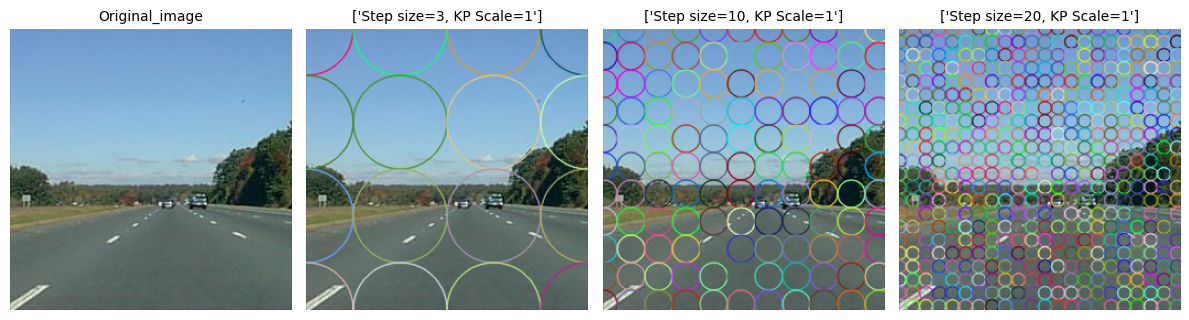

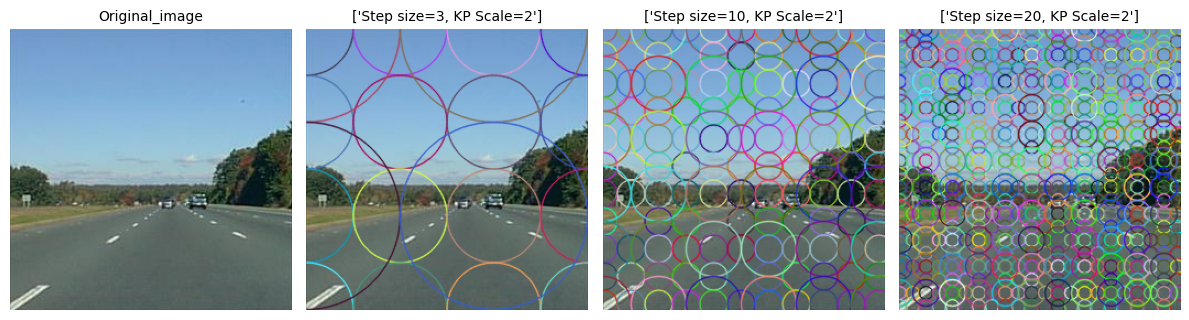

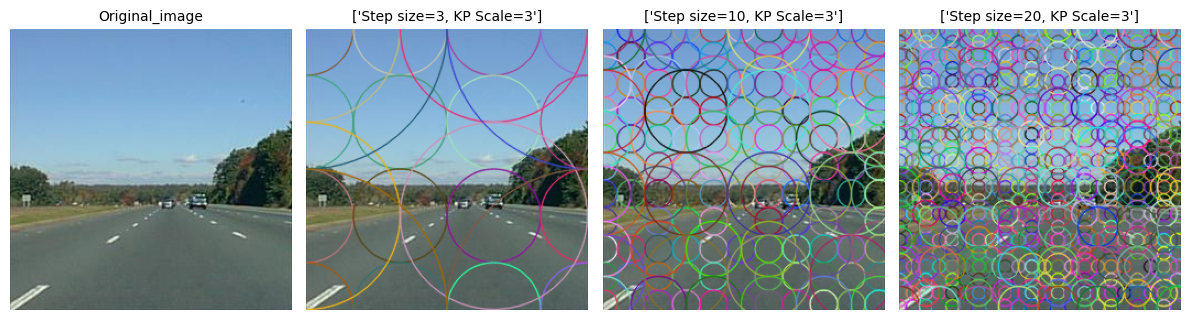

In [204]:
steps = [3,10,20]

dense_kp = []
scale = 1
for step in steps:
    dense_kp.append(create_dense_kp(gray.shape, step_div_size=step, kp_sizes=scale))
    # _, dense_sift_des = SIFTdetector.compute(gray, dense_kp[counter])
show_keypoints(sample, dense_kp=dense_kp, steps=steps, scale=scale)

dense_kp = []
scale = 2
for step in steps:
    dense_kp.append(create_dense_kp(gray.shape, step_div_size=step, kp_sizes=scale))
    # _, dense_sift_des = SIFTdetector.compute(gray, dense_kp[counter])
show_keypoints(sample, dense_kp=dense_kp, steps=steps, scale=scale)

dense_kp = []
scale = 3
for step in steps:
    dense_kp.append(create_dense_kp(gray.shape, step_div_size=step, kp_sizes=scale))
    # _, dense_sift_des = SIFTdetector.compute(gray, dense_kp[counter])
show_keypoints(sample, dense_kp=dense_kp, steps=steps, scale=scale)

For example, if an image is 300x300 and "step_div_size" is 30, the keypoints will be created every 10 pixels horizontally and vertically. Additionally, we have added a new parameter "num_sizes" to emulate scale-covariance, which is not present in Dense SIFT, but present in Vanilla SIFT. 

With "num_sizes" set to 2, the algorithm creates keypoints at different scales (1, and 2), with half the keypoints at each scale, but double the size of the keypoints.

### Testing the Dense Sift

We perform a GridSearch experiment with the following list of parameteres:

- Pyramid level: 0 (None)
- Step size: 5, 8, 10, 12, 15, 20, 30
- KP Scale: 1, 2, 3, 6, 10
- Codebook: 1000

In [205]:
df_dense_sift = pd.read_csv('results/hyper_params_dense_sift_svm.csv')
df = df_dense_sift.copy().sort_values(by=['Accuracy'], ascending=False)
df[['Descriptor','Step size','KP Scale','Accuracy']].head()

Descriptor  Step size  KP Scale  Accuracy
28  DENSE SIFT         20         6  0.848494
29  DENSE SIFT         20        10  0.842127
34  DENSE SIFT         30        10  0.842120
27  DENSE SIFT         20         3  0.841586
26  DENSE SIFT         20         2  0.841066

We have used the Dense SIFT descriptor and have done a GridSearch to find the best hyper-parameters. An important note is that we have used only one codebook size (1000) in our tests, as we saw no real benefit in increasing it after this point. A higher codebook size may have lead to a slight increase in accuracy, but the computational cost increase was not justified. 

The table shows our top 5 results in terms of validation accuracy. The highest value achieved with the specified parameters (Step size = 20 and KP Scale = 6) is 0.85 accuracy. 

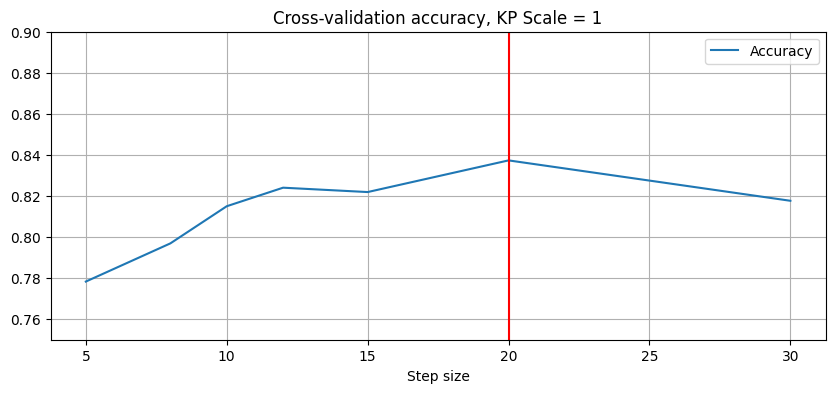

In [206]:
df = df_dense_sift.copy()[df_dense_sift['KP Scale'] == 1]
df.plot.line(
    x='Step size',
    y='Accuracy',
    title='Cross-validation accuracy, KP Scale = 1',
    figsize=(10,4),
    grid=True,
    ylim=(0.75,0.9),
    
)
plt.axvline(20, color='red')

In the plot above, we fixed the KP Scale to 1 and we produced result varying step sizes:
- Step size: 5, 8, 10, 12, 15, 20, 30

The Cross-validation accuracy **fluctuated between 0.76 and 0.84**. From this we extract that choosing a proper step size is important. We **fix step_size=20** from now on. 

<AxesSubplot: title={'center': 'Cross-validation accuracy, Step size = 20'}, xlabel='KP Scale'>

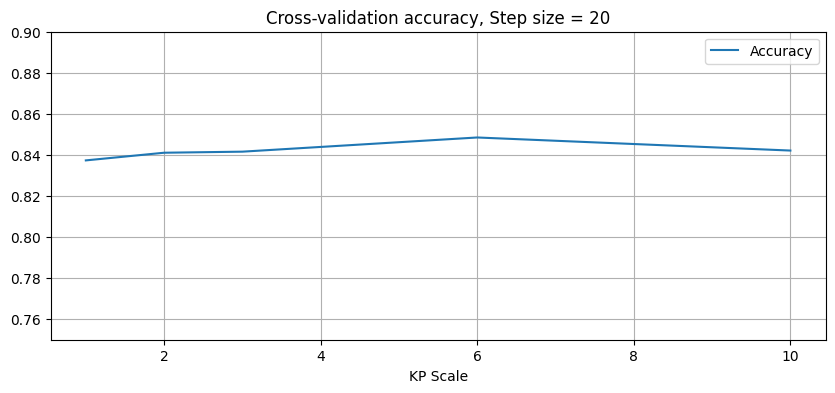

In [207]:
df = df_dense_sift.copy()[df_dense_sift['Step size'] == 20]
df.plot.line(
    x='KP Scale',
    y='Accuracy',
    title='Cross-validation accuracy, Step size = 20',
    figsize=(10,4),
    grid=True,
    ylim=(0.75,0.9)
) 

In the plot above, we fixed the step size to 20 and we produced result varying KP Scale:
- KP Scale: 1, 2, 3, 6, 10

The Cross-validation accuracy **fluctuated between 0.838 and 0.844**. From this we extract that choosing a proper is not very important. Even if it does produce the best results, we will fix **KP Scale to 1** from now on because is computationally cheaper than the alternatives. 

## 4. Normalization <a id="normalization"></a>


Normalization is the process of scaling individual samples to have unit norm, to have features in the same scale and improve model performance. We use it to normalize the histograms of visual words.

The normalized feature vector is 
$$
x_{\text {norm }} = \frac{x}{N}
$$
with

- **Power norm** $\to$ components of the feature vector sum 1
$$
N = \|x\|_{1} = \sum_{i}(x_{i})
$$

- **L2 norm (euclidean)** $\to$ modulus of the feature vector is 1
$$
N = \|x\|_{2} = \sqrt{\sum_{i}x_i^2}
$$

- **Standar Scaler** $\to$ remove the mean and scale to unit variance
$$
x_{\text {norm }}=\frac{x-\mu}{\sigma} ; \quad \mu: \text{mean}, \ \sigma: \text{std}
$$

In [157]:
def normalization(X: np.ndarray, norm='scaler'):
    if norm == 'l2':
        return normalize(X, norm='l2')

    elif norm == 'power':
        return X/np.sum([X],axis=-1).reshape(X.shape[0],-1)
        
    elif norm == 'scaler':
        return StandardScaler().fit_transform(X)

Normalizing the histogram of visual words is crucial in spatial pyramids, as we will discuss later. Therefore, we will experiment with different normalization methods in Section 5, Spatial Pyramids.

## 5. Spatial Pyramids <a id="pyramids"></a>

The Bag of Visual Words method effectively collects local features into one global vector, but it disregards any information about the spatial arrangement of the features. To address this issue, we calculate keypoints and descriptors at various pyramidal levels. 

The spatial pyramid approach subdivides the image into smaller and smaller regions and computes the histograms of the codewords within each region. With all the per-level information we can later classify more accurately.

### 5.1. Squared pyramid regions <a id="squared"></a>

In [227]:
def spatial_pyramid_square(img, descriptor, level=1, step_div_size=20, kp_sizes=1, plot=False):

    # create dense keypoints and compute descriptors
    dense_kp = create_dense_kp(img.shape, step_div_size=step_div_size, kp_sizes=kp_sizes)
    _,des = descriptor.compute(img, dense_kp)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    # for visualization purposes
    if plot:
        fig = plt.figure(figsize=(12,4))
        gs = fig.add_gridspec(4*level, 4+4*level)
        ax = fig.add_subplot(gs[:, :4])
        ax.imshow(img)
        ax.axis('off')

    # list that contains the descriptors of img at different levels,
    # being pyramid_descriptors[0] the descriptors of the whole image
    pyramid_descriptors = [des]

    for l in range(1,level+1):
        level_factor = 2*l
        cell_h = int(gray.shape[0]/level_factor)
        cell_w = int(gray.shape[1]/level_factor)
        
        dense_kp_cell = create_dense_kp([cell_h,cell_w], step_div_size=step_div_size, kp_sizes=kp_sizes)
            
        for f_h in range(level_factor):
            shift_h = f_h*cell_h
            for f_w in range(level_factor):
                shift_w = f_w*cell_w
                cell = img[shift_h:shift_h+cell_h, shift_w:shift_w+cell_w]
                _,des = descriptor.compute(cell, dense_kp_cell)
                pyramid_descriptors.append(des)

                # for visualization purposes
                if plot:
                    init_row = f_h*4//l
                    last_row = init_row + 4//l
                    init_col = f_w*4//(2*l) + 4*l
                    last_col = init_col + 4//(2*l)
                    ax = fig.add_subplot(gs[init_row:last_row, init_col:last_col])
                    ax.imshow(img[shift_h:shift_h+cell_h, shift_w:shift_w+cell_w])
                    ax.axis('off')
                    ax.set_title(f'Level {l}', fontsize=9)

    fig.tight_layout()
    return pyramid_descriptors

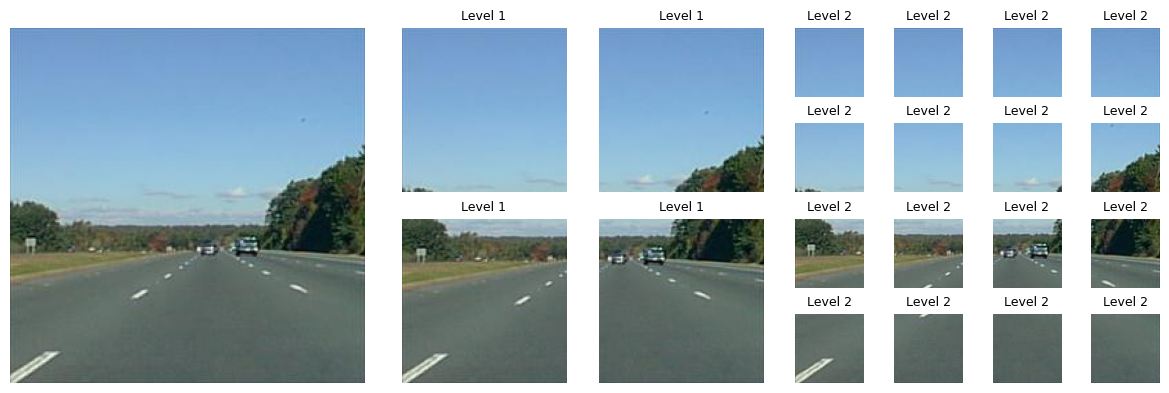

In [228]:
img_blocks = spatial_pyramid_square(img, SIFTdetector, level=2, plot=True)

As can be seen in the representation above, Squared Spatial Pyramids divide the image into a fixed grid of non-overlapping squares, and extract features from each square. This method is simple and easy to implement, but it is not very flexible, as it does not take into account the aspect ratio of the regions.

We perform a GridSearch experiment with the following list of parameteres:

- Pyramid level: 1, 2 (squared)
- Normalization: l2, power, scaler
- Step size: 12
- KP Scale: 1
- Codebook: 500

In [239]:
df_squared_pyramids = pd.read_csv('results/hyper_params_squared_pyramids.csv')
pd.pivot_table(df_squared_pyramids, values='Accuracy', index=['Pyramid level'], columns=['Norm'])

Norm                 l2     power    scaler
Pyramid level                              
1              0.832001  0.827234  0.834676
2              0.831487  0.822974  0.827234

### 5.2. Horizontal pyramid regions <a id="horizontal"></a>

Horizontal Spatial Pyramids, on the other hand, divide the image into a fixed grid of non-overlapping rectangles, which can have different aspect ratios. This method is more flexible than squared spatial pyramids, as it can adapt to different shapes and sizes of regions in the image, and it can be more robust to the variations of the object of interest.

In [220]:
def spatial_pyramid_horizontal(img, descriptor, level=1, step_div_size=20, num_sizes=1, plot=False):

    # create dense keypoints and compute descriptors
    dense_kp = create_dense_kp(img.shape, step_div_size=step_div_size, kp_sizes=num_sizes)
    _,des = descriptor.compute(img, dense_kp)

    # list that contains the descriptors of img at different levels,
    # being pyramid_descriptors[0] the descriptors of the whole image
    pyramid_descriptors = [des]

    # for visualization purposes
    if plot:
        fig = plt.figure(figsize=(12,4))
        gs = fig.add_gridspec(3*level, 3+3*level)
        ax = fig.add_subplot(gs[:, :3])
        ax.imshow(img)
        ax.axis('off')
        
    for l in range(1,level+1):
        level_factor = 3*l
        cell_h = int(gray.shape[0]/level_factor)
        
        dense_kp_cell = create_dense_kp([cell_h,gray.shape[1]], step_div_size=step_div_size, kp_sizes=num_sizes)
            
        for f_h in range(level_factor):
            shift_h = f_h*cell_h
            cell = img[shift_h:shift_h+cell_h,:]

            _,des = descriptor.compute(cell, dense_kp_cell)

            pyramid_descriptors.append(des)

            # for visualization purposes
            if plot:
                init_row = f_h*(3*level)//(3*l)
                last_row = init_row + (3*level)//(3*l)
                ax = fig.add_subplot(gs[init_row:last_row, 3*l:3*l+3])
                ax.imshow(img[shift_h:shift_h+cell_h,:])
                ax.axis('off')
                ax.set_title(f'Level {l}', fontsize=9)

    fig.tight_layout()
    return pyramid_descriptors

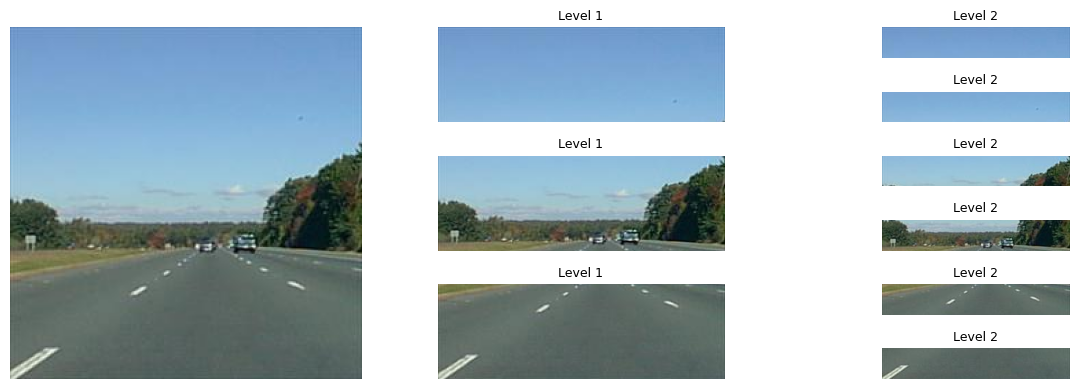

In [230]:
img_blocks = spatial_pyramid_horizontal(img[...,::-1], SIFTdetector, level=2, plot=True)

In theory, Horizontal Spatial Pyramids are more general and are able to capture more information than Squared Spatial Pyramids, but they are also more computationally intensive. This, however, is not clearly reflected in our tests. We found both of these approaches to give similar results, and the best was with a Squared Spatial Pyramid (alt-ought the difference in accuracy between the Horizontal approach was is almost negligible).

In [243]:
df_horizontal_pyramids = pd.read_csv('results/hyper_params_horizontal_pyramids.csv')
pd.pivot_table(df_horizontal_pyramids, values='Accuracy', index=['Pyramid level'], columns=['Norm'])

Norm                 l2     power    scaler
Pyramid level                              
1              0.843067  0.839343  0.838823
2              0.837747  0.839339  0.834579

## 3. SVM Classifier <a id="svm"></a>

In [26]:
def histogram_intersection(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
    """
    Function that implements a histogram intersection. This can be used as a Kernel for svm.SVC

    Args:
        X (np.ndarray): First histogram
        Y (np.ndarray): Second histogram
    """
    inter_kernel = np.zeros((X.shape[0], Y.shape[0]))
    for x_col, y_col in zip(X, Y):
        inter_kernel += np.minimum(x_col, y_col) 
    return inter_kernel

In [27]:
def svm_classifier_fit(trial: int, X_train: np.ndarray, Y_train: np.ndarray, X_test: np.ndarray) -> np.ndarray:
        """
        Function that implements a SVM classifier. This function is used for hyperparameter optimization of parameters C and kernel.

        Args:
                trial (int): Trial number
                X_train (np.ndarray): Training data
                Y_train (np.ndarray): Training labels
                X_test (np.ndarray): Test data
        """
        c = trial.suggest_float("C", 1.0, 2.0)
        kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid", histogram_intersection])
        degree = 3
        coef0 = 0.0
        gamma = "scale"
        if kernel == "poly":
                degree = trial.suggest_categorical("poly_degree", [3, 4, 5])
        if kernel == "sigmoid" or kernel == "poly":
                coef0 = trial.suggest_float("coef0", 0.0, 1.0)
        if kernel == "rbf" or kernel == "sigmoid" or kernel == "poly":
                gamma = trial.suggest_categorical("gamma", ["scale", "auto"])
        svc = SVC(C=c, kernel=kernel, degree=degree, coef0=coef0, gamma=gamma ,random_state=0)
        svc.fit(X_train, Y_train)
        Y_test = svc.predict(X_test)
        
        return Y_test

In [28]:
def objective(trial, descriptors: np.ndarray, labels: np.ndarray, codebook: MiniBatchKMeans, codebook_size: int) -> float:
    """
    Function that implements the objective function for hyperparameter optimization. This function is used for hyperparameter optimization of parameters C and kernel.
    
    Args:
        descriptors (np.ndarray): precomputed descriptors
        labels (np.ndarray): Labels
        codebook (MiniBatchKMeans): Codebook
        codebook_size (int): Codebook size
    """
    n_splits = 5
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0).split(descriptors, labels)
    cumulative_accuracy = 0
    is_first_fold = True
    for train_index, test_index in tqdm(folds, "Fold", leave=False):
        X_train, Y_train = descriptors[train_index], train_labels[train_index]
        X_val, Y_val = descriptors[train_index], train_labels[train_index]
        
        vw_train, vw_val = compute_visual_words(X_train, X_val)
        X_train_DR, X_validate_DR = dimensionality_reduction(vw_train, Y_train, vw_val)
        predictions = svm_classifier_fit(trial, X_train_DR, Y_train, X_validate_DR)
        val_score = accuracy_score(y_true=Y_val, y_pred=predictions)
        cumulative_accuracy += val_score

        # fix trial for following folds. All params must be same accross folds
        if is_first_fold:
            is_first_fold = False
            trial = optuna.trial.FixedTrial(trial.params)

    accuracy = cumulative_accuracy / n_splits

    return accuracy

In [29]:
# Wrap the objective inside a lambda and call objective inside it
func = lambda trial: objective(trial, descriptors=train_descriptors, labels=test_labels, codebook=codebook, codebook_size=codebook_size)

study = optuna.create_study(direction="maximize", study_name='svm-study', storage='sqlite:///final60.db', load_if_exists=True)
study.optimize(func, n_trials=50)

[I 2023-01-13 02:33:14,502] Using an existing study with name 'svm-study' instead of creating a new one.
[W 2023-01-13 02:33:14,523] Trial 3 failed because of the following error: NameError("name 'codebook' is not defined")
Traceback (most recent call last):
  File "/Users/eduard.hogea/miniforge3/envs/cv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/9m/k3vyv4317cz56g6f681k4jnm0000gn/T/ipykernel_52109/2691449830.py", line 2, in <lambda>
    func = lambda trial: objective(trial, descriptors=train_descriptors, labels=test_labels, codebook=codebook, codebook_size=codebook_size)
NameError: name 'codebook' is not defined


NameError: name 'codebook' is not defined

### Testing the BOVW with SVM

In [ ]:
params = {
    'detector': ['dense_sift'],
    'n_features': [2000],
    'codebook_size': [1024,2048],
    'step_size': [5,10,20,30,50],
    'dr_methods': ["pca", "lda"],
    'kp_sizes=kp_sizes': [1,2,3,4,8,10],
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [1.0,2.0,3.0]
}

evaluation_metrics = ['accuracy', 'f1_weighted']
results_folder = 'results'
filename = 'hyper_params_svm.csv'

results = []

for n_features in params['n_features']:
    for step_div_size in params['step_size']:
        for kp_sizes in params['kp_sizes']:

            train_descriptors, filtered_train_labels = compute_descriptors(
                images=train_images,
                labels=train_labels,
                detector='dense_sift',
                n_features=n_features,
                step_div_size = step_div_size,
                kp_sizes = kp_sizes,
                desc='Computing descriptors for TRAIN images...'
            )


            for codebook_size in params['codebook_size']:

                cbook = generate_codebook(train_descriptors, codebook_size=codebook_size)
                train_visual_words = compute_visual_words(
                    descriptors=train_descriptors,
                    codebook=cbook,
                    codebook_size=codebook_size,
                    desc="Computing visual words vocabulary with TRAIN descriptors..."
                )
            clf = svm.SVC()
            clf_grid = GridSearchCV(
                estimator=clf,
                param_grid={k: params[k] for k in ('kernel', 'C') if k in params},
                cv=8,
                scoring=evaluation_metrics,
                refit="accuracy",
                return_train_score=True)
            clf_grid.fit(train_visual_words, filtered_train_labels)

            idx_best_accuracy = np.argmin(clf_grid.cv_results_['rank_test_accuracy'])

            # Params
            kernel = clf_grid.best_params_['kernel']
            C = clf_grid.best_params_['C']

            results_data = ['dense_sift', n_features, step_div_size, kp_sizes,codebook_size, kernel, C]

            # Scores
            for eval_metric in evaluation_metrics:
                train_score = clf_grid.cv_results_['mean_train_' + eval_metric][idx_best_accuracy]
                val_score = clf_grid.cv_results_['mean_test_' + eval_metric][idx_best_accuracy]
                std_train_score = clf_grid.cv_results_['std_train_' + eval_metric][idx_best_accuracy]
                std_val_score = clf_grid.cv_results_['std_test_' + eval_metric][idx_best_accuracy]
                results_data.extend([train_score, val_score, std_train_score, std_val_score])

            results.append(results_data)
            print(f"Appended GridSearchCV results for {'dense_sift'} with {n_features} features, {step_div_size} step size, {kp_sizes} kp scale and {codebook_size} codebook size.")

columns = ['detector', 'n_features','step_size', 'kp_sizes', 'codebook_size', 'kernel', 'C'] \


for eval_metric in evaluation_metrics:
    columns.extend([f'train_{eval_metric}', f'val_{eval_metric}', f'std_train_{eval_metric}', f'std_val_{eval_metric}'])

In [ ]:
df = pd.DataFrame(results, columns=columns)
os.makedirs(results_folder, exist_ok=True)
df.to_csv(os.path.join(results_folder, filename))
print(f"Saved results to {os.path.join(results_folder, filename)}")